# ⚙️ Feature Importance Analysis

This notebook focuses on advanced feature analysis using machine learning models to understand feature importance and build predictive insights.

## 🎯 Objectives
- Build XGBoost models for feature importance analysis
- Apply SHAP for model interpretability
- Analyze numerical and categorical features separately
- Generate actionable insights for model development
- Create feature selection recommendations

In [9]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
from src.data.data_loader import load_raw_data, basic_data_info, save_processed_data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine learning libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score

# SHAP for model interpretation
try:
    import shap
    shap_available = True
except ImportError:
    print("⚠️ SHAP not available. Install with: pip install shap")
    shap_available = False

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

## 📊 Load Data and Prepare Features

In [10]:
# Load the cleaned dataset
try:
    df_clean = pd.read_csv('../../data/processed/cleaned_data.csv')
    print(f"📊 Loaded cleaned dataset: {df_clean.shape}")
except FileNotFoundError:
    print("❌ Cleaned dataset not found. Please run previous notebooks first.")
    raise

# Re-categorize features
cat_cols = []
num_cols = []

for col in df_clean.columns:
    if any(prefix in col for prefix in ['cd_', 'zip_', 'year_', 'flg_', 'type', 'city', 'state']):
        cat_cols.append(col)
    else:
        num_cols.append(col)

# Add priority to categorical if it exists
if 'priority' in df_clean.columns and 'priority' not in cat_cols:
    cat_cols.append('priority')
    if 'priority' in num_cols:
        num_cols.remove('priority')

print(f"📈 Numerical features: {len(num_cols)}")
print(f"🏷️ Categorical features: {len(cat_cols)}")
print(f"🎯 Target variable: flg_leads ({df_clean['flg_leads'].value_counts().to_dict()})")

📊 Loaded cleaned dataset: (48578, 48)
📈 Numerical features: 8
🏷️ Categorical features: 40
🎯 Target variable: flg_leads ({1: 37967, 0: 10611})


## 🔢 Numerical Features Analysis

### Binned Analysis for Numerical Features

In [11]:
def binned_target_analysis(df, feature, target, bins=10):
    """Analyze target distribution across binned feature values"""
    df_copy = df.copy()
    df_copy[f'{feature}_binned'] = pd.cut(df_copy[feature], bins=bins)
    
    analysis = df_copy.groupby(f'{feature}_binned')[target].agg([
        'count', 'mean', 'sum'
    ]).reset_index()
    
    analysis['percentage'] = (analysis['count'] / analysis['count'].sum()) * 100
    return analysis

print("📊 Binned Analysis for Numerical Features:")
binned_insights = {}

for col in num_cols:
    if col not in ['leads', 'flg_leads']:
        binned_analysis = binned_target_analysis(df_clean, col, 'leads', bins=10)
        
        max_count = binned_analysis['count'].max()
        proportion_max = max_count / binned_analysis['count'].sum()
        min_count = binned_analysis['count'].min()
        max_bin = binned_analysis.loc[binned_analysis['count'].idxmax(), f'{col}_binned']
        
        binned_insights[col] = {
            "max_count": max_count,
            "proportion_max": proportion_max,
            "min_count": min_count,
            "dominant_bin": str(max_bin),
            "mean_leads_range": binned_analysis['mean'].max() - binned_analysis['mean'].min()
        }
        
        print(f"\n{col}:")
        print(f"  - Dominant bin: {max_bin} ({proportion_max:.1%} of data)")
        print(f"  - Mean leads range across bins: {binned_insights[col]['mean_leads_range']:.2f}")

print(f"\n✅ Completed binned analysis for {len(binned_insights)} numerical features")

📊 Binned Analysis for Numerical Features:

views:
  - Dominant bin: (-93.608, 9360.8] (99.9% of data)
  - Mean leads range across bins: 4.42

phone_clicks:
  - Dominant bin: (-0.457, 45.7] (98.5% of data)
  - Mean leads range across bins: 308.46

vl_advertise:
  - Dominant bin: (-1200.0, 120000.0] (93.5% of data)
  - Mean leads range across bins: 4.42

n_photos:
  - Dominant bin: (6.0, 8.0] (68.6% of data)
  - Mean leads range across bins: 6.22

km_vehicle:
  - Dominant bin: (-1320.0, 132000.0] (91.9% of data)
  - Mean leads range across bins: 4.10

vl_market:
  - Dominant bin: (5377.897, 97787.478] (91.4% of data)
  - Mean leads range across bins: 6.30

n_doors:
  - Dominant bin: (3.6, 4.0] (88.6% of data)
  - Mean leads range across bins: 2.35

✅ Completed binned analysis for 7 numerical features


### XGBoost Feature Importance - Numerical Features

In [13]:

# Prepare numerical features for modeling
print("🚀 Building XGBoost Regressor for numerical features...")

# Select numerical features (excluding target variables)
numerical_features = [col for col in num_cols if col not in ["leads", "flg_leads"]]
print(f"📊 Using {len(numerical_features)} numerical features: {numerical_features}")

# Prepare data
X_num = df_clean[numerical_features].fillna(0)
y = df_clean["leads"]

# Train-test split
X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_num, y, test_size=0.25, random_state=42
)

print(f"📈 Training set: {X_train_num.shape}")
print(f"📉 Validation set: {X_val_num.shape}")

# Build XGBoost regression model
model_num = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric="rmse"
)

# Train model
model_num.fit(X_train_num, y_train)

# Make predictions
y_pred = model_num.predict(X_val_num)

# Evaluate model
rmse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"\n📊 Model Performance on Validation Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


🚀 Building XGBoost Regressor for numerical features...
📊 Using 7 numerical features: ['views', 'phone_clicks', 'vl_advertise', 'n_photos', 'km_vehicle', 'vl_market', 'n_doors']
📈 Training set: (36433, 7)
📉 Validation set: (12145, 7)

📊 Model Performance on Validation Set:
RMSE: 55.2533
MAE: 3.1899
R² Score: 0.6587


🏆 Top 10 Most Important Numerical Features:


,feature,importance_gain
1,phone_clicks,13628.359375
4,km_vehicle,814.847229
6,n_doors,799.659912
5,vl_market,789.518860
2,vl_advertise,784.359375
3,n_photos,696.934814
0,views,614.700562


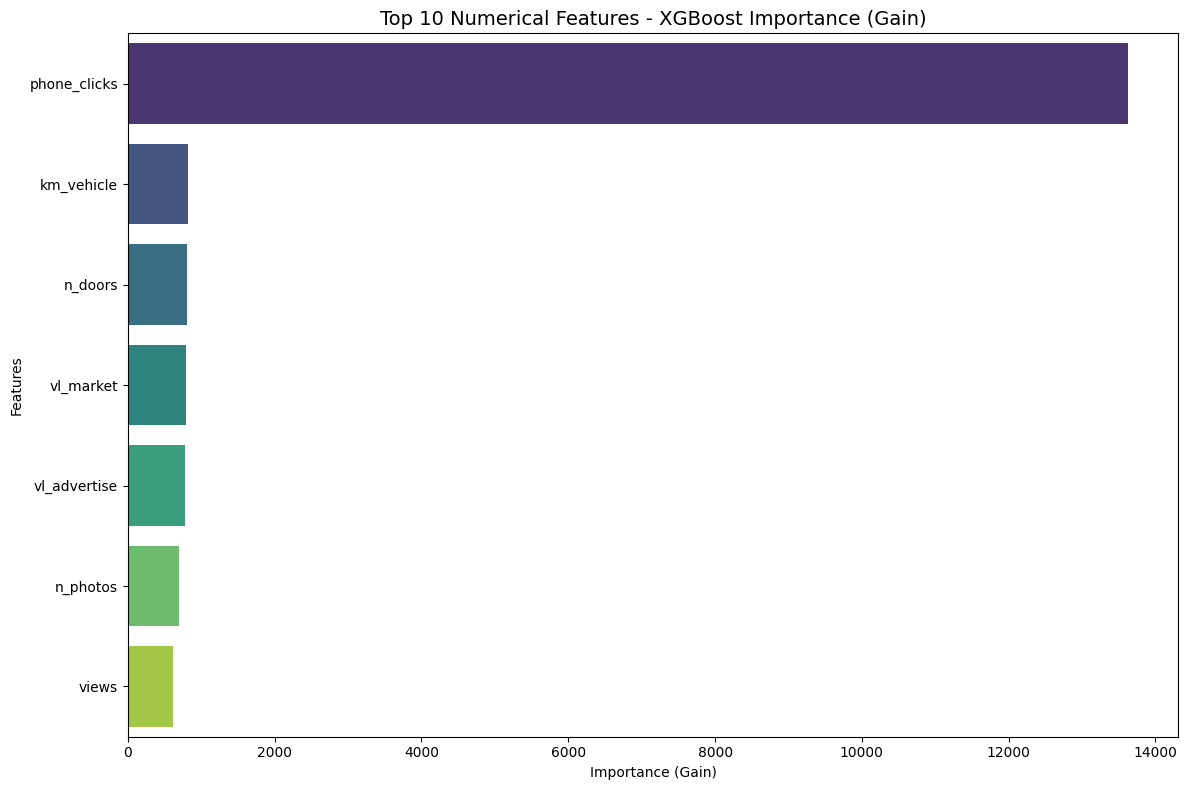

In [14]:
# Extract feature importance
importance_num = model_num.get_booster().get_score(importance_type='gain')
feature_importance_num = pd.DataFrame({
    'feature': list(importance_num.keys()),
    'importance_gain': list(importance_num.values())
}).sort_values(by='importance_gain', ascending=False)

print("🏆 Top 10 Most Important Numerical Features:")
display(feature_importance_num.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_num.head(10)
sns.barplot(data=top_features, x='importance_gain', y='feature', palette='viridis')
plt.title('Top 10 Numerical Features - XGBoost Importance (Gain)', fontsize=14)
plt.xlabel('Importance (Gain)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### SHAP Analysis - Numerical Features

🔍 SHAP Analysis for Numerical Features...


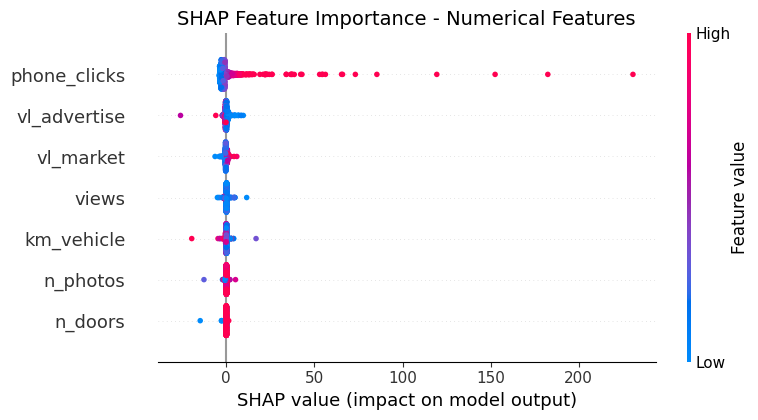


🎯 Top Features by SHAP Importance:


,feature,shap_importance
1,phone_clicks,4.563079
2,vl_advertise,0.616890
5,vl_market,0.435940
0,views,0.373903
4,km_vehicle,0.263229
3,n_photos,0.198722
6,n_doors,0.052241


In [15]:
if shap_available:
    print("🔍 SHAP Analysis for Numerical Features...")
    
    # Create SHAP explainer
    explainer_num = shap.Explainer(model_num)
    
    # Calculate SHAP values (using a sample for efficiency)
    sample_size = min(1000, len(X_train_num))
    X_sample = X_train_num.sample(sample_size, random_state=42)
    shap_values_num = explainer_num(X_sample)
    
    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.plots.beeswarm(shap_values_num, max_display=10, show=False)
    plt.title('SHAP Feature Importance - Numerical Features', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # SHAP feature importance
    shap_importance_num = pd.DataFrame({
        'feature': X_sample.columns,
        'shap_importance': np.abs(shap_values_num.values).mean(0)
    }).sort_values('shap_importance', ascending=False)
    
    print("\n🎯 Top Features by SHAP Importance:")
    display(shap_importance_num.head(10))
    
else:
    print("⚠️ SHAP analysis skipped - library not available")

## 🏷️ Categorical Features Analysis

### Feature Selection for Categorical Analysis

In [16]:
# Select categorical features for analysis (excluding high cardinality ID features)
categorical_features = [
    col for col in cat_cols 
    if not col.startswith('cd_') or col == 'cd_type_individual'
]

# Remove target variables and problematic features
categorical_features = [
    col for col in categorical_features 
    if col not in ['flg_leads', 'city']  # Exclude city due to high cardinality
]

print(f"🏷️ Selected {len(categorical_features)} categorical features for modeling:")
for i, feature in enumerate(categorical_features, 1):
    nunique = df_clean[feature].nunique()
    print(f"  {i:2d}. {feature} ({nunique} unique values)")

# Check for any features with too high cardinality
high_cardinality = [f for f in categorical_features if df_clean[f].nunique() > 100]
if high_cardinality:
    print(f"\n⚠️ High cardinality features (>100 unique): {high_cardinality}")
    categorical_features = [f for f in categorical_features if f not in high_cardinality]
    print(f"🔧 Final feature count: {len(categorical_features)}")

🏷️ Selected 33 categorical features for modeling:
   1. cd_type_individual (2 unique values)
   2. year_model (63 unique values)
   3. zip_2dig (98 unique values)
   4. flg_single_owner (2 unique values)
   5. flg_lincese (2 unique values)
   6. flg_tax_paid (2 unique values)
   7. flg_all_dealership_services (2 unique values)
   8. flg_all_dealership_schedule_vehicle (2 unique values)
   9. flg_factory_warranty (2 unique values)
  10. flg_armored (2 unique values)
  11. flg_trade_in (2 unique values)
  12. flg_pcd (2 unique values)
  13. transmission_type (7 unique values)
  14. flg_alarm (2 unique values)
  15. flg_airbag (2 unique values)
  16. flg_heater (2 unique values)
  17. flg_leather_seats (2 unique values)
  18. flg_air_conditioning (2 unique values)
  19. flg_abs (2 unique values)
  20. flg_rear_defogger (2 unique values)
  21. flg_electric_locks (2 unique values)
  22. flg_electric_windows (2 unique values)
  23. flg_alloy_wheels (2 unique values)
  24. flg_rain_sensor (2 

### XGBoost Feature Importance - Categorical Features

In [17]:
# Prepare categorical features for modeling
print("🚀 Building XGBoost model for categorical features...")

# Prepare data
df_cat = df_clean[categorical_features + ['flg_leads']].copy()

# Handle missing values
for col in categorical_features:
    df_cat[col] = df_cat[col].fillna('Unknown')

# Encode categorical features
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_cat_encoded = encoder.fit_transform(df_cat[categorical_features])
X_cat = pd.DataFrame(X_cat_encoded, columns=categorical_features)

y = df_cat["flg_leads"]

# Train-test split
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    X_cat, y, test_size=0.25, random_state=42, stratify=y
)

print(f"📈 Training set: {X_train_cat.shape}")
print(f"📉 Validation set: {X_val_cat.shape}")

# Build XGBoost model
model_cat = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Train model
model_cat.fit(X_train_cat, y_train_cat)

# Make predictions
y_pred_cat = model_cat.predict(X_val_cat)
y_pred_proba_cat = model_cat.predict_proba(X_val_cat)[:, 1]

# Evaluate model
roc_auc_cat = roc_auc_score(y_val_cat, y_pred_proba_cat)
print(f"\n📊 Categorical Model Performance:")
print(f"ROC-AUC Score: {roc_auc_cat:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_val_cat, y_pred_cat))

🚀 Building XGBoost model for categorical features...
📈 Training set: (36433, 33)
📉 Validation set: (12145, 33)

📊 Categorical Model Performance:
ROC-AUC Score: 0.5658

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      2653
           1       0.78      1.00      0.88      9492

    accuracy                           0.78     12145
   macro avg       0.64      0.50      0.44     12145
weighted avg       0.72      0.78      0.69     12145



🏆 Top 10 Most Important Categorical Features:


,feature,importance_gain
0,cd_type_individual,6.599082
2,zip_2dig,4.021432
9,flg_armored,3.155426
18,flg_abs,3.145164
15,flg_heater,2.841834
23,flg_rain_sensor,2.833469
17,flg_air_conditioning,2.802744
27,flg_gasolina,2.769140
12,transmission_type,2.754792
13,flg_alarm,2.749067


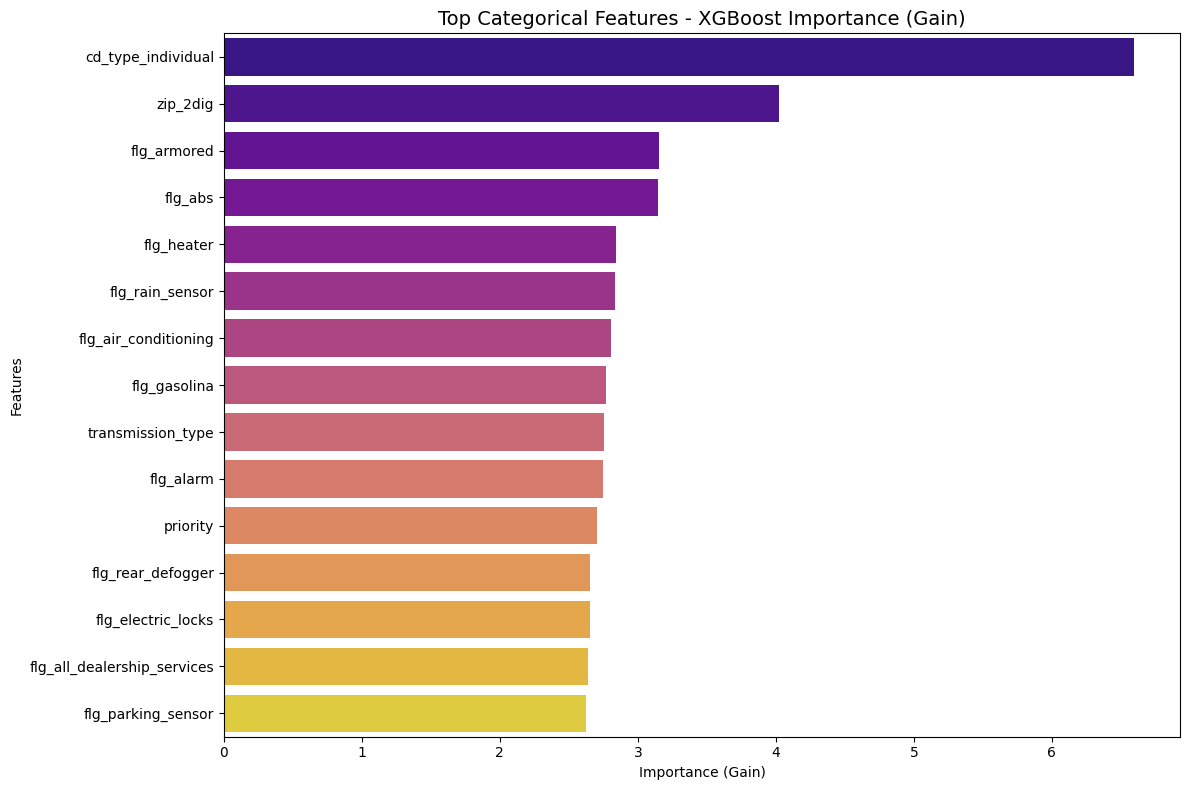

In [18]:
# Extract feature importance for categorical features
importance_cat = model_cat.get_booster().get_score(importance_type='gain')
feature_importance_cat = pd.DataFrame({
    'feature': list(importance_cat.keys()),
    'importance_gain': list(importance_cat.values())
}).sort_values(by='importance_gain', ascending=False)

print("🏆 Top 10 Most Important Categorical Features:")
display(feature_importance_cat.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_cat = feature_importance_cat.head(min(15, len(feature_importance_cat)))
sns.barplot(data=top_features_cat, x='importance_gain', y='feature', palette='plasma')
plt.title('Top Categorical Features - XGBoost Importance (Gain)', fontsize=14)
plt.xlabel('Importance (Gain)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### SHAP Analysis - Categorical Features

🔍 SHAP Analysis for Categorical Features...


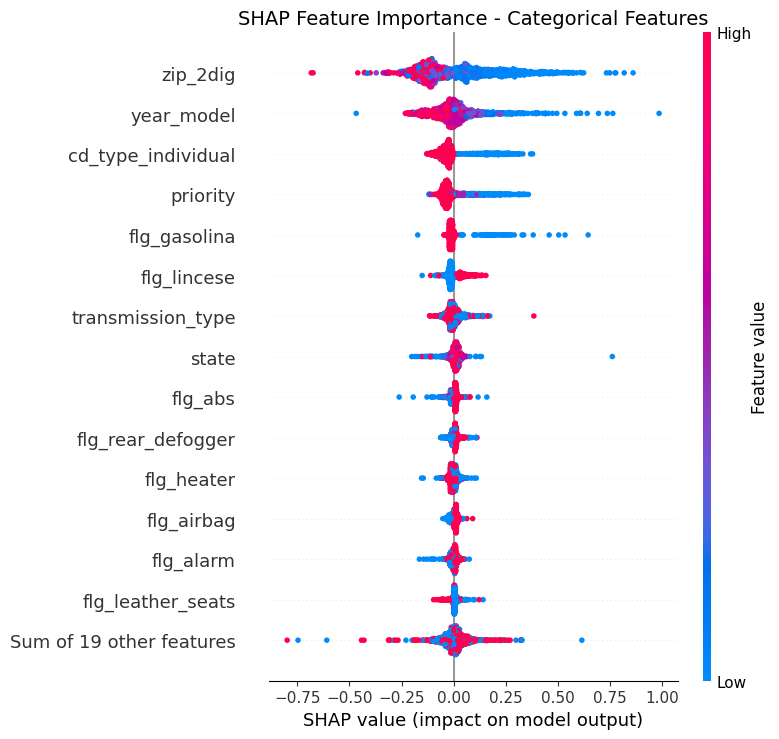


🎯 Top Categorical Features by SHAP Importance:


,feature,shap_importance
2,zip_2dig,0.160762
1,year_model,0.079195
0,cd_type_individual,0.063459
32,priority,0.057102
27,flg_gasolina,0.025881
4,flg_lincese,0.025144
12,transmission_type,0.023837
25,state,0.019424
18,flg_abs,0.014127
19,flg_rear_defogger,0.012996


In [19]:
if shap_available:
    print("🔍 SHAP Analysis for Categorical Features...")
    
    # Create SHAP explainer
    explainer_cat = shap.Explainer(model_cat)
    
    # Calculate SHAP values (using a sample for efficiency)
    sample_size = min(1000, len(X_train_cat))
    X_sample_cat = X_train_cat.sample(sample_size, random_state=42)
    shap_values_cat = explainer_cat(X_sample_cat)
    
    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.plots.beeswarm(shap_values_cat, max_display=15, show=False)
    plt.title('SHAP Feature Importance - Categorical Features', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # SHAP feature importance
    shap_importance_cat = pd.DataFrame({
        'feature': X_sample_cat.columns,
        'shap_importance': np.abs(shap_values_cat.values).mean(0)
    }).sort_values('shap_importance', ascending=False)
    
    print("\n🎯 Top Categorical Features by SHAP Importance:")
    display(shap_importance_cat.head(10))
    
else:
    print("⚠️ SHAP analysis skipped - library not available")

## 🏅 Combined Feature Importance Analysis

🏅 Combined Feature Importance Analysis:

🔝 Top 15 Most Important Features (All Types):


,feature,normalized_importance,feature_type
1,phone_clicks,1.000000,Numerical
0,cd_type_individual,1.000000,Categorical
2,zip_2dig,0.609393,Categorical
9,flg_armored,0.478161,Categorical
18,flg_abs,0.476606,Categorical
15,flg_heater,0.430641,Categorical
23,flg_rain_sensor,0.429373,Categorical
17,flg_air_conditioning,0.424717,Categorical
27,flg_gasolina,0.419625,Categorical
12,transmission_type,0.417451,Categorical


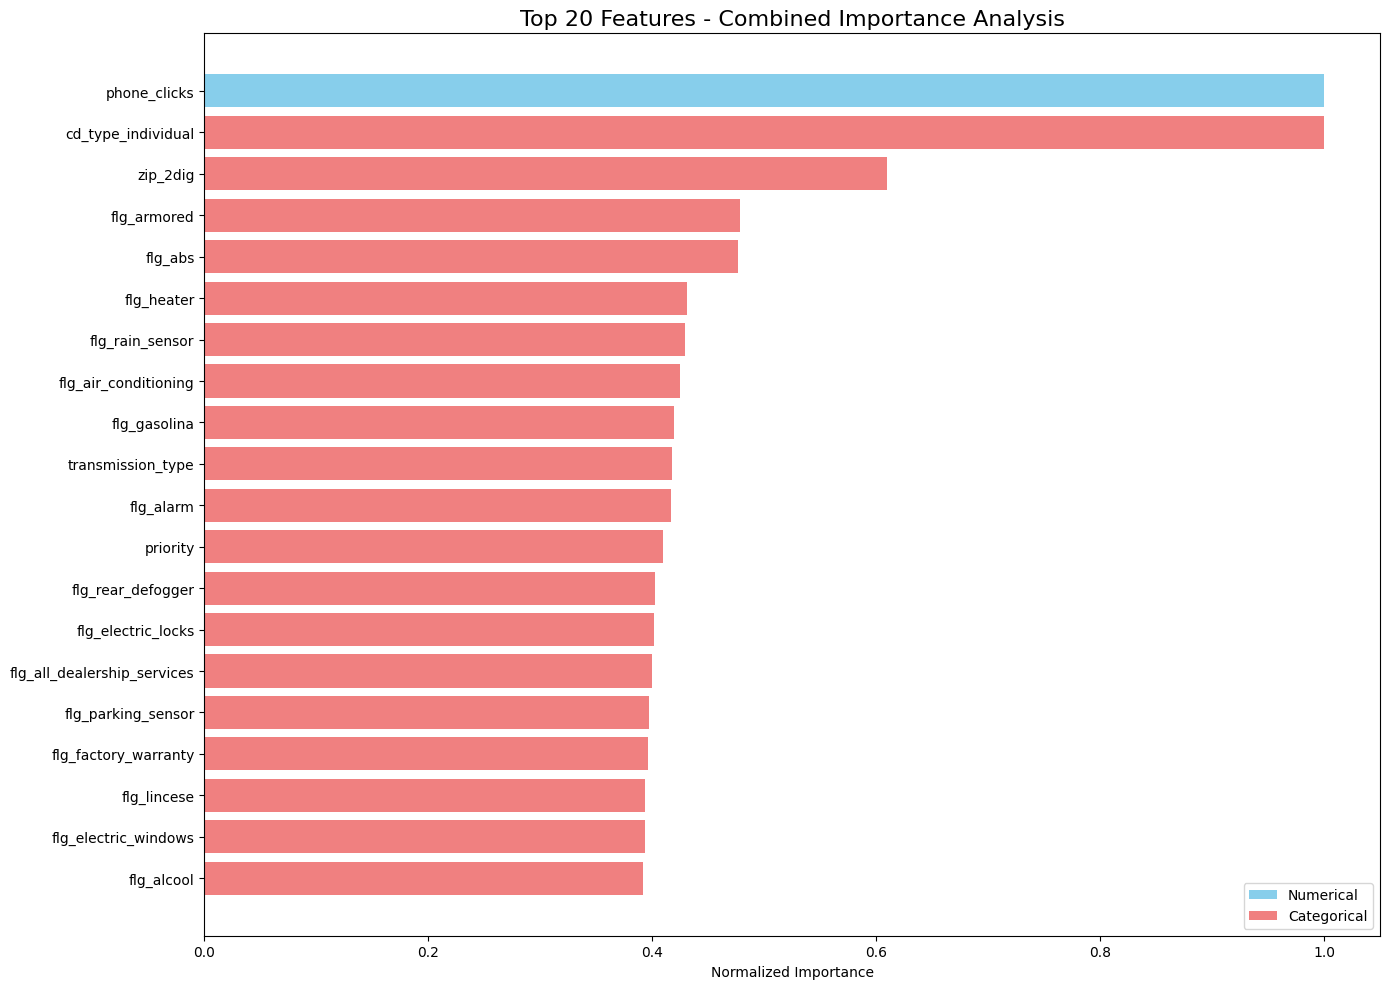

In [20]:
# Combine feature importance from both models
print("🏅 Combined Feature Importance Analysis:")

# Normalize importance scores
feature_importance_num['normalized_importance'] = (
    feature_importance_num['importance_gain'] / feature_importance_num['importance_gain'].max()
)
feature_importance_cat['normalized_importance'] = (
    feature_importance_cat['importance_gain'] / feature_importance_cat['importance_gain'].max()
)

# Add feature type
feature_importance_num['feature_type'] = 'Numerical'
feature_importance_cat['feature_type'] = 'Categorical'

# Combine
combined_importance = pd.concat([
    feature_importance_num[['feature', 'normalized_importance', 'feature_type']],
    feature_importance_cat[['feature', 'normalized_importance', 'feature_type']]
]).sort_values('normalized_importance', ascending=False)

print(f"\n🔝 Top 15 Most Important Features (All Types):")
display(combined_importance.head(15))

# Visualize combined importance
plt.figure(figsize=(14, 10))
top_combined = combined_importance.head(20)
colors = ['skyblue' if ft == 'Numerical' else 'lightcoral' for ft in top_combined['feature_type']]
bars = plt.barh(range(len(top_combined)), top_combined['normalized_importance'], color=colors)
plt.yticks(range(len(top_combined)), top_combined['feature'])
plt.xlabel('Normalized Importance')
plt.title('Top 20 Features - Combined Importance Analysis', fontsize=16)
plt.gca().invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='Numerical'),
                   Patch(facecolor='lightcoral', label='Categorical')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 📊 Model Performance Comparison

In [21]:
# Compare model performances
performance_comparison = pd.DataFrame({
    'Model': ['Numerical Features', 'Categorical Features'],
    'r2/ROC-AUC': [r2, roc_auc_cat],
    'Features_Count': [len(numerical_features), len(categorical_features)]
})

print("📊 Model Performance Comparison:")
display(performance_comparison)

# Feature importance summary by type
feature_type_summary = combined_importance.groupby('feature_type').agg({
    'normalized_importance': ['count', 'mean', 'sum', 'max']
}).round(3)

print("\n📈 Feature Importance Summary by Type:")
display(feature_type_summary)

📊 Model Performance Comparison:


,Model,r2/ROC-AUC,Features_Count
0,Numerical Features,0.658655,7
1,Categorical Features,0.565846,33



📈 Feature Importance Summary by Type:


normalized_importance                    
                             count   mean     sum  max
feature_type                                          
Categorical                     33  0.386  12.738  1.0
Numerical                        7  0.190   1.330  1.0

## 💡 Feature Selection Recommendations

In [24]:
# Generate feature selection recommendations
print("💡 FEATURE SELECTION RECOMMENDATIONS")
print("=" * 50)

# Top features for modeling
top_numerical = feature_importance_num.head(5)['feature'].tolist()
top_categorical = feature_importance_cat.head(5)['feature'].tolist()

print(f"\n🔢 TOP NUMERICAL FEATURES:")
for i, feature in enumerate(top_numerical, 1):
    importance = feature_importance_num[feature_importance_num['feature'] == feature]['normalized_importance'].iloc[0]
    print(f"  {i}. {feature} (importance: {importance:.3f})")

print(f"\n🏷️ TOP CATEGORICAL FEATURES:")
for i, feature in enumerate(top_categorical, 1):
    importance = feature_importance_cat[feature_importance_cat['feature'] == feature]['normalized_importance'].iloc[0]
    print(f"  {i}. {feature} (importance: {importance:.3f})")

# Feature engineering recommendations
print(f"\n🔧 FEATURE ENGINEERING RECOMMENDATIONS:")
print(f"\n1. 📈 NUMERICAL FEATURES:")
print(f"   - Focus on top performers: {', '.join(top_numerical[:3])}")
print(f"   - Apply log transformation to skewed features")
print(f"   - Consider binning for better interpretability")
print(f"   - Create interaction features between top performers")

print(f"\n2. 🏷️ CATEGORICAL FEATURES:")
print(f"   - Prioritize: {', '.join(top_categorical[:3])}")
print(f"   - Use target encoding for high cardinality features")
print(f"   - Group rare categories into 'Other'")
print(f"   - Consider feature combinations for flag variables")


💡 FEATURE SELECTION RECOMMENDATIONS

🔢 TOP NUMERICAL FEATURES:
  1. phone_clicks (importance: 1.000)
  2. km_vehicle (importance: 0.060)
  3. n_doors (importance: 0.059)
  4. vl_market (importance: 0.058)
  5. vl_advertise (importance: 0.058)

🏷️ TOP CATEGORICAL FEATURES:
  1. cd_type_individual (importance: 1.000)
  2. zip_2dig (importance: 0.609)
  3. flg_armored (importance: 0.478)
  4. flg_abs (importance: 0.477)
  5. flg_heater (importance: 0.431)

🔧 FEATURE ENGINEERING RECOMMENDATIONS:

1. 📈 NUMERICAL FEATURES:
   - Focus on top performers: phone_clicks, km_vehicle, n_doors
   - Apply log transformation to skewed features
   - Consider binning for better interpretability
   - Create interaction features between top performers

2. 🏷️ CATEGORICAL FEATURES:
   - Prioritize: cd_type_individual, zip_2dig, flg_armored
   - Use target encoding for high cardinality features
   - Group rare categories into 'Other'
   - Consider feature combinations for flag variables
